In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd

In [3]:
# import data
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/met_geo_cats/cleaned_rough_lstm_geo_met_cat_orange.parquet"
)
df.head()

,valid_time,time,station_ADDI,latitude_ADDI,longitude_ADDI,t2m_ADDI,sh2_ADDI,d2m_ADDI,r2_ADDI,u10_ADDI,...,26_aspect_WBOU,31_aspect_WBOU,33_aspect_WBOU,32_aspect_WBOU,34_aspect_WBOU,38_aspect_WBOU,std_elev_WBOU,variance_elev_WBOU,skew_elev_WBOU,med_dist_elev_WBOU
0,2018-01-01 03:00:00,2018-01-01 01:00:00,ADDI,42.045955,-77.218867,-19.199194,0.00068,-21.993216,76.800003,3.321081,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
1,2018-01-01 04:00:00,2018-01-01 02:00:00,ADDI,42.045955,-77.218867,-19.118689,0.00068,-21.918570,76.500000,3.298830,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
2,2018-01-01 05:00:00,2018-01-01 03:00:00,ADDI,42.045955,-77.218867,-19.439062,0.00065,-22.570868,73.800003,2.992857,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
3,2018-01-01 06:00:00,2018-01-01 04:00:00,ADDI,42.045955,-77.218867,-19.760291,0.00063,-22.821158,74.400002,3.115693,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
4,2018-01-01 07:00:00,2018-01-01 05:00:00,ADDI,42.045955,-77.218867,-19.860175,0.00062,-22.993704,74.099998,3.268302,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986


In [4]:
for k in df.keys():
    print(k)

valid_time
time
station_ADDI
latitude_ADDI
longitude_ADDI
t2m_ADDI
sh2_ADDI
d2m_ADDI
r2_ADDI
u10_ADDI
v10_ADDI
tp_ADDI
mslma_ADDI
orog_ADDI
tcc_ADDI
asnow_ADDI
cape_ADDI
dswrf_ADDI
dlwrf_ADDI
gh_ADDI
u_total_ADDI
u_dir_ADDI
new_tp_ADDI
lat_ADDI
lon_ADDI
elev_ADDI
tair_ADDI
ta9m_ADDI
td_ADDI
relh_ADDI
srad_ADDI
pres_ADDI
mslp_ADDI
wspd_sonic_ADDI
wmax_sonic_ADDI
wdir_sonic_ADDI
precip_total_ADDI
snow_depth_ADDI
11_nlcd_ADDI
21_nlcd_ADDI
22_nlcd_ADDI
23_nlcd_ADDI
24_nlcd_ADDI
31_nlcd_ADDI
41_nlcd_ADDI
42_nlcd_ADDI
43_nlcd_ADDI
52_nlcd_ADDI
71_nlcd_ADDI
81_nlcd_ADDI
82_nlcd_ADDI
90_nlcd_ADDI
95_nlcd_ADDI
19_aspect_ADDI
21_aspect_ADDI
24_aspect_ADDI
27_aspect_ADDI
28_aspect_ADDI
22_aspect_ADDI
23_aspect_ADDI
25_aspect_ADDI
26_aspect_ADDI
31_aspect_ADDI
33_aspect_ADDI
32_aspect_ADDI
34_aspect_ADDI
38_aspect_ADDI
std_elev_ADDI
variance_elev_ADDI
skew_elev_ADDI
med_dist_elev_ADDI
time_ADDI
station
latitude
longitude
t2m
sh2
d2m
r2
u10
v10
tp
mslma
orog
tcc
asnow
cape
dswrf
dlwrf
gh
u_total
u_

In [6]:
len(df["new_tp_OLEA"])

23618

In [7]:
# now we can estimate the IMFs for the signal
x = df["new_tp_OLEA"]
imf = emd.sift.sift(x)
print(imf.shape)

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(23618, 11)


and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [8]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [9]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

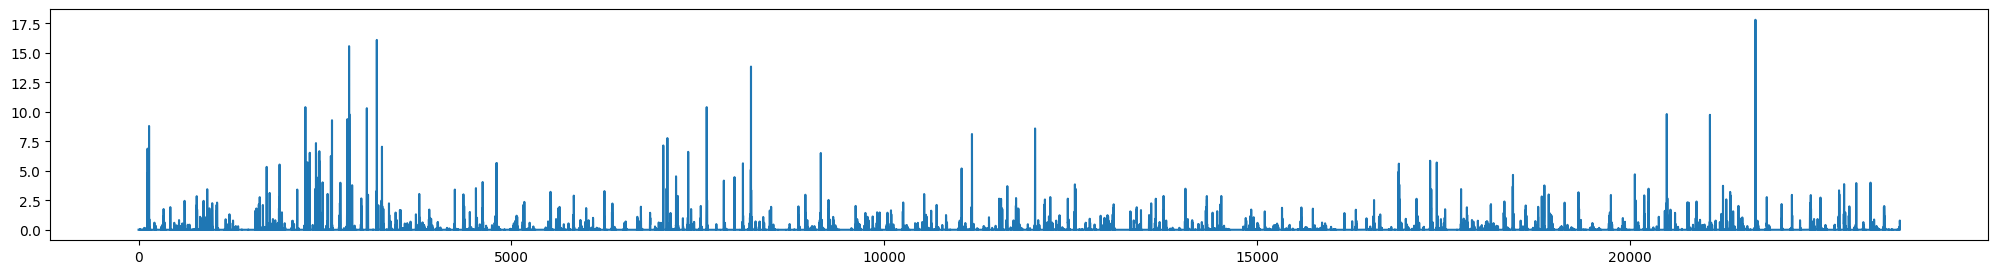

In [10]:
# visualize
fig = plt.figure(figsize=(25, 3))
plt.plot(df["new_tp_OLEA"])

Plot the IMFs

<Axes: xlabel='Time (samples)'>

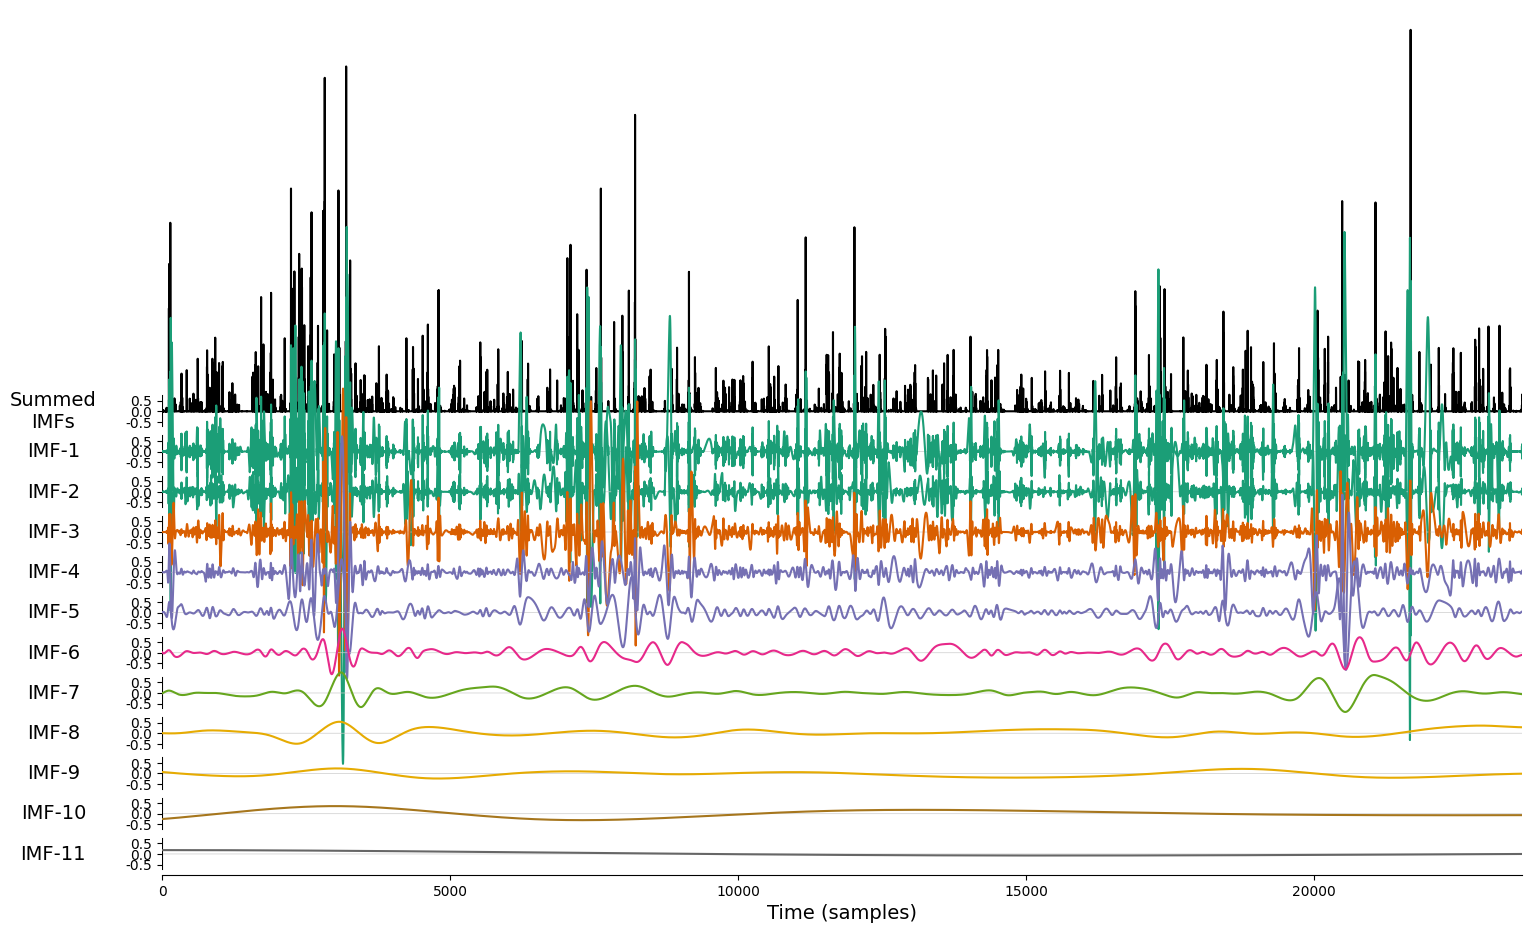

In [11]:
emd.plotting.plot_imfs(imf)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

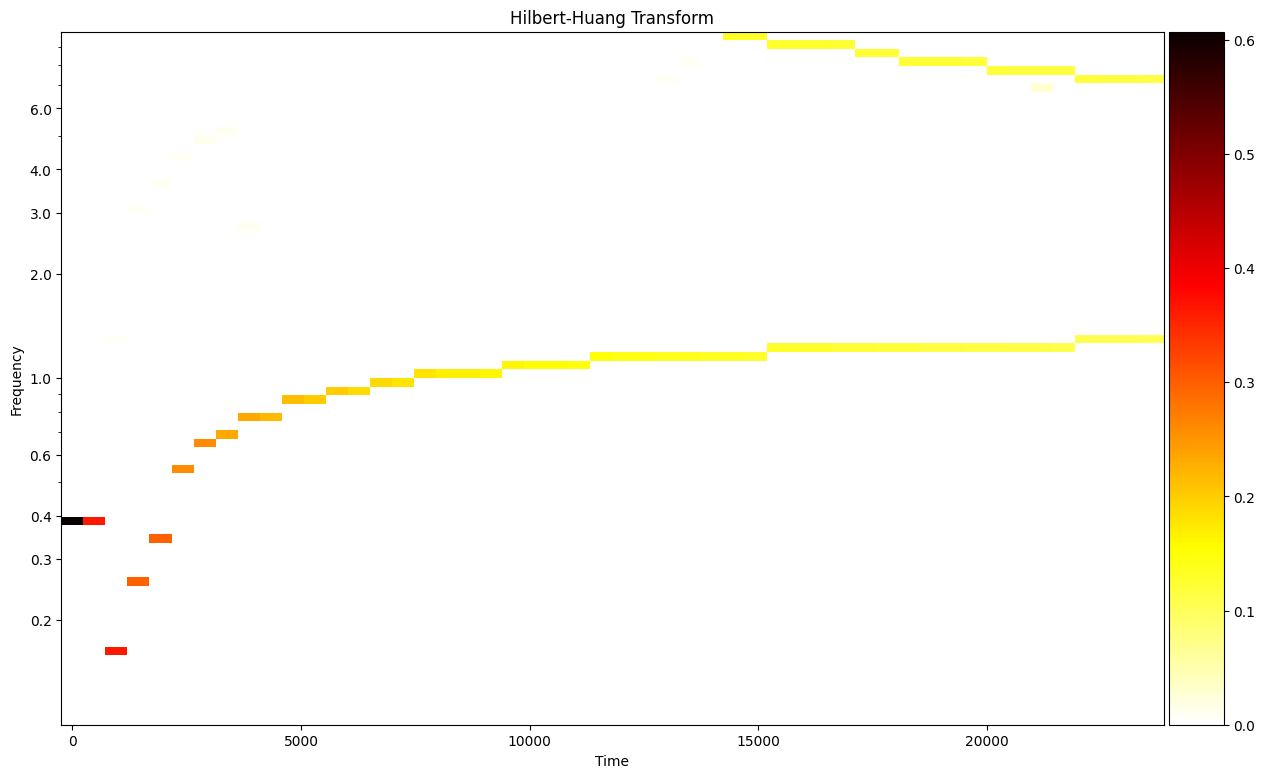

In [12]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [13]:
imf_opts = {"sd_thresh": 0.05}

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

<Axes: xlabel='Time (samples)'>

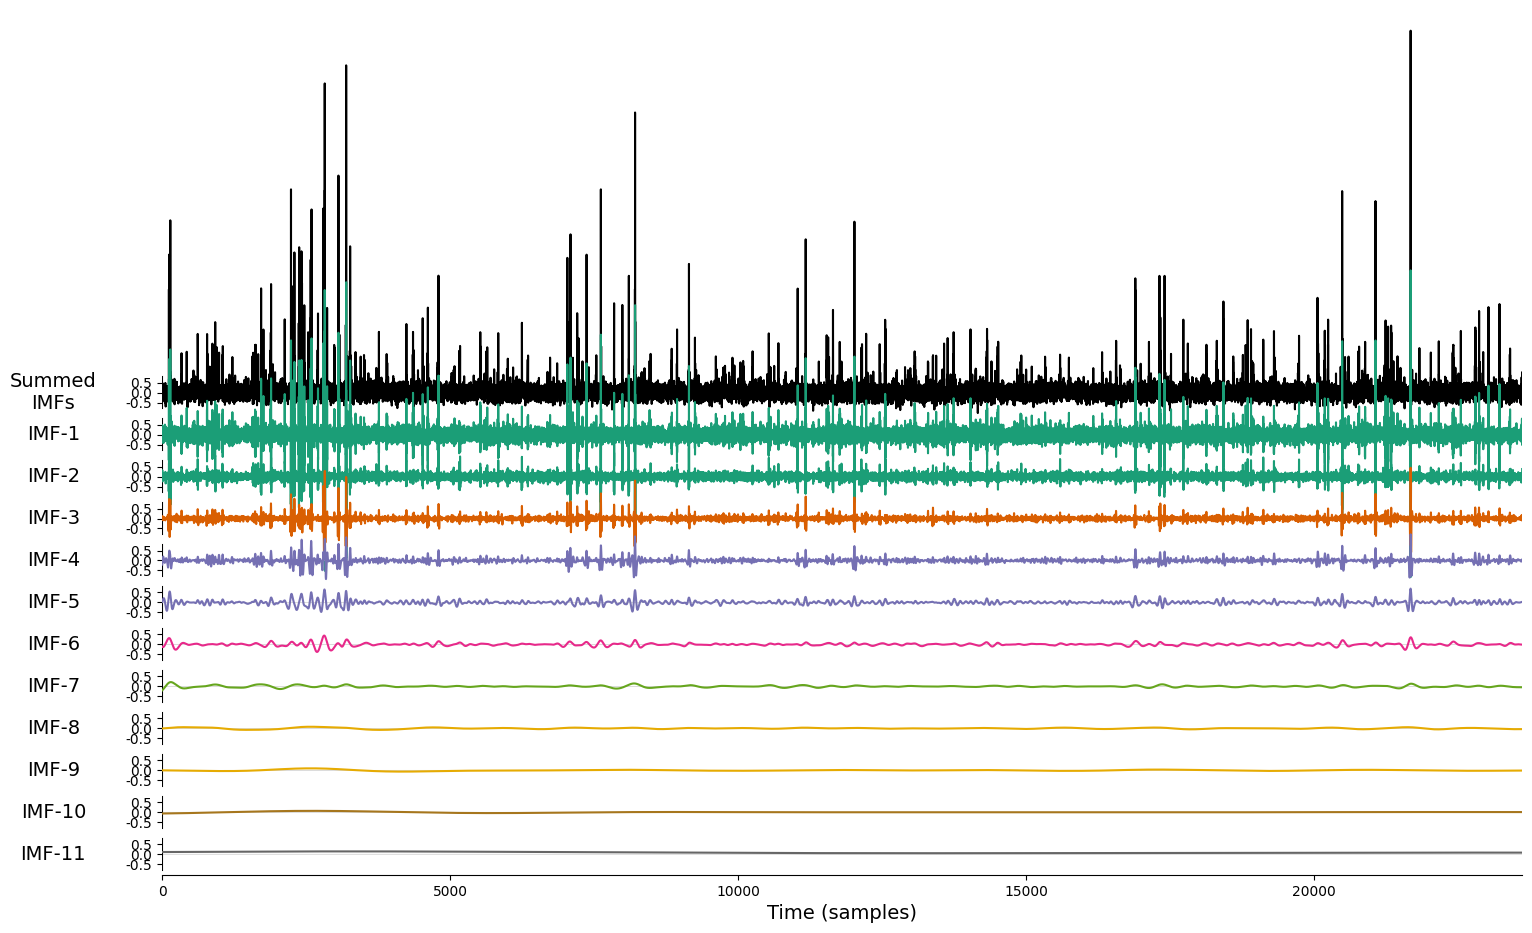

In [24]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=3, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [15]:
imf.shape

(23618, 11)

and now the Hilbert-Huang transform of this decomposition

In [16]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

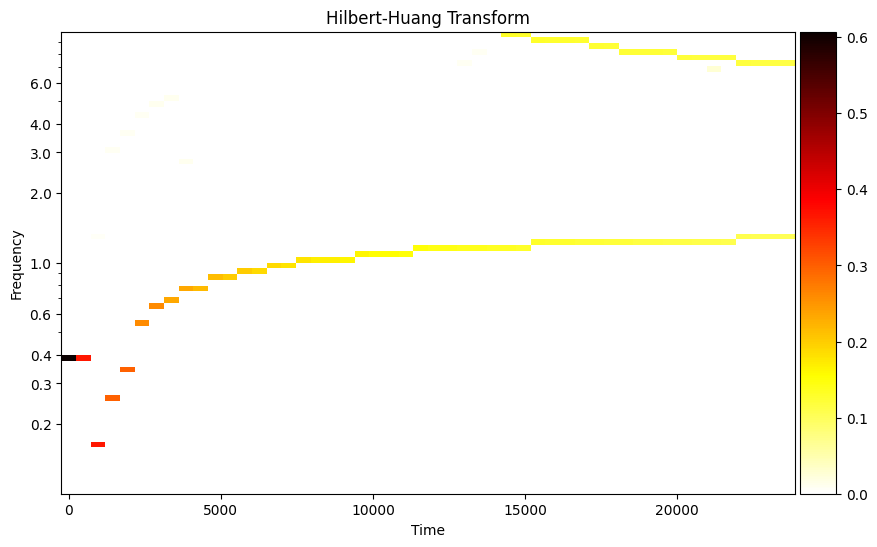

In [17]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)